# FOREST COVER PREDICTION

## Import necessory packages

In [187]:
import warnings
import numpy as np
import pandas as pd
from collections import Counter 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sb


In [3]:
#to remove warnings
warnings.simplefilter("ignore")

In [4]:
#collecting data from file
data = pd.read_csv("train.csv")

## Simple EDA checks

### 1.check the data is readed correctly or not

In [76]:
data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### 2.checking for the data shape

In [77]:
data.shape

(15120, 56)

### 3.check the data have any null value 

In [ ]:
data.isnull().sum()

from the above we can see that there is no null values in the data set

### 4.checking the data is balanced or not

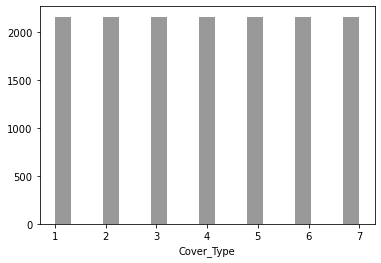

In [188]:
sb.distplot(data.Cover_Type,kde=False,color="black")

from the above graph we can see that the data is equeally distributed. hence it is a balanced data set

### 5.checking skewness and curtosis

In [189]:
print("skew of covertype : ",stats.skew(data.Cover_Type))
print("kurtosis of Covertypestats : ",stats.kurtosis(data.Cover_Type))

skew of covertype :  0.0
kurtosis of Covertypestats :  -1.25


our data output has a negative kurtosis

### assigning X and Y values

In [9]:
X = data.iloc[:,:-1]
y = data.Cover_Type

## 1.Droping features with no values


In [10]:
columns = X.columns
droped_columns = []
for col_name in  columns:
    mean = np.mean(X.loc[:,[col_name]])
    if mean.any() == 0.0:
        droped_columns.append(col_name)
        X.drop(col_name,axis = 1,inplace = True)
print("\n\nDropped Coloms = ",droped_columns)



Dropped Coloms =  ['Soil_Type7', 'Soil_Type15']


## 2.Findining Variance Threshold to drop features

In [11]:
# finding columns with low variance and droping those columns
varience = VarianceThreshold(0.003)
varience.fit(X)

VarianceThreshold(threshold=0.003)

In [12]:
var = varience.get_support()
print(var)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False  True False False  True  True  True  True  True False  True
 False False  True  True  True]


In [13]:
column_names= X.columns
X_var = X.copy()

In [14]:
rem_colmn = X_var.columns[varience.get_support() == False]
print("columns which has low varience : \n\n",rem_colmn)
print(X_var.drop(rem_colmn,inplace=True,axis=1))
print("we have dropped " +str(len(rem_colmn))+ " coloumns using threshold varience")
print("current shape of data set : ",X_var.shape)

columns which has low varience : 

 Index(['Soil_Type8', 'Soil_Type9', 'Soil_Type21', 'Soil_Type25', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37'],
      dtype='object')
None
we have dropped 9 coloumns using threshold varience
current shape of data set :  (15120, 44)


## 3.Converting all the values to a scale (std_scalar)

In [15]:
scale = StandardScaler()
scaled_X_var = scale.fit_transform(X_var)
scaled_X_var.shape

(15120, 44)

## 4.Finding PCA to drop Features

In [214]:
model = PCA(n_components=40)
X_scaled_pca = model.fit_transform(scaled_X_var)
X_scaled_pca = pd.DataFrame(scaled_X_var)
model.explained_variance_ratio_.sum()

0.9983722615885102

 while considering the first 40 components of PCA out we get 99.83 percent of total data

In [313]:
#reducing the columns to 40
X_scaled_pca = X_scaled_pca.iloc[:,:-4]
X_scaled_pca.shape

(15120, 40)

## Train_Test_Split

In [122]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled_pca,y,random_state=10)


# MODELLING

## 1.Modelling with XGBoost

In [132]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.8801587301587301

In [133]:
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,423,90,1,0,4,0,25
2,73,377,14,0,40,13,6
3,0,5,443,19,7,31,0
4,0,0,10,549,0,3,0
5,3,15,5,0,516,5,0
6,1,5,51,9,4,479,0
7,11,2,0,0,1,0,540


### finding percentage distribution for each catogory in output(Y)

In [190]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 81.69811320754718
percentage considering  2  is 91.15789473684211
percentage considering  3  is 84.07766990291262
percentage considering  4  is 74.39862542955326
percentage considering  5  is 77.32142857142857
percentage considering  6  is 79.59558823529412
percentage considering  7  is 75.43554006968641


## Finding Cross Validation Score

In [135]:
cross_val  = cross_val_score(model,X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.32473545 0.47255291 0.52314815 0.5271164  0.57275132]
maximum accuracy :  0.5727513227513228
minimum accuracy :  0.3247354497354497
average accuracy :  0.4840608465608465


eventhough, my XGBclassifier model gives 88 % in modelling but while considering cross validation score it gives a very small accurary hence XGB_classifier is not a good model for my data beacause this model leads to overfitting problem. |hence i change the model to Support_Vector_machine  

## 2.Modelling with SVM

In [136]:
model = SVC()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.7441798941798942

In [216]:
#cross_tab
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,435,71,1,0,6,0,30
2,81,375,11,0,34,16,6
3,0,4,428,25,5,43,0
4,0,0,14,545,0,3,0
5,2,12,6,0,518,6,0
6,0,7,48,15,1,478,0
7,10,0,0,0,0,0,544


### finding percentage distribution for each catogory in output(Y)

In [138]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 65.33101045296166
percentage considering  2  is 77.31958762886599
percentage considering  3  is 73.2421875
percentage considering  4  is 59.42947702060222
percentage considering  5  is 67.3249551166966
percentage considering  6  is 76.53061224489795
percentage considering  7  is 70.62146892655367


## Finding Cross Validation Score

In [139]:
cross_val  = cross_val_score(SVC(),X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.53835979 0.59689153 0.66335979 0.66534392 0.66732804]
maximum accuracy :  0.6673280423280423
minimum accuracy :  0.5383597883597884
average accuracy :  0.6262566137566138


support vector machine gives a low accuracy as well as low cross validation score as compared to XGboost

## 3.Modelling with Random Forest

In [205]:
model = RandomForestClassifier(n_estimators=150,random_state=10,max_depth=50,min_samples_split=2)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.879100529100529

In [217]:
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,435,71,1,0,6,0,30
2,81,375,11,0,34,16,6
3,0,4,428,25,5,43,0
4,0,0,14,545,0,3,0
5,2,12,6,0,518,6,0
6,0,7,48,15,1,478,0
7,10,0,0,0,0,0,544


### finding percentage distribution for each catogory in output(Y)

In [219]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 82.38636363636364
percentage considering  2  is 92.75053304904051
percentage considering  3  is 85.62992125984252
percentage considering  4  is 74.35897435897436
percentage considering  5  is 77.12765957446808
percentage considering  6  is 79.67032967032966
percentage considering  7  is 75.0


## Finding Cross Validation Score

In [206]:
cross_val  = cross_val_score(RandomForestClassifier(),X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.44246032 0.59953704 0.68055556 0.72519841 0.75231481]
maximum accuracy :  0.7523148148148148
minimum accuracy :  0.44246031746031744
average accuracy :  0.6400132275132275


### While considering 3 models Random Forest gives a consistancy in output ,hence taking Random Forest as main model

# Hyper_Parameter_Tuning(GridSearchCV)

In [202]:
params = { "n_estimators":[100,125,150],
           "random_state":[10,13,42],
           "max_depth": [10,20,50],
           "min_samples_split" : [2,4,7]
         }
grid_out = GridSearchCV(RandomForestClassifier(),params,scoring="accuracy",verbose=2)
grid_out.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.6s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.4s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.4s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.4s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=13, total=   1.6s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=13, total=   1.4s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_

[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.6s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.4s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=42, total=   1.6s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=42, total=   1.5s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_

[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.6s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.4s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_depth=10, min_samples_split=7, n_estimators=125, random_state=10, total=   1.9s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_depth=10, min_samples_split=7, n_estimators=125, random_state=10, total=   1.7s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_

[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   2.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   2.5s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   2.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   2.6s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=13, total=   2.8s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=13, total=   2.6s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_

[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.5s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.6s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=42, total=   2.5s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=42, total=   2.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_

[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.4s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.6s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.5s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.6s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_depth=20, min_samples_split=7, n_estimators=150, random_state=10, total=   2.9s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_depth=20, min_samples_split=7, n_estimators=150, random_state=10, total=   3.1s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_

[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   3.2s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   3.3s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   3.3s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   3.1s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=13, total=   3.4s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=13, total=   3.4s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_

[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   3.3s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   3.3s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   3.1s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   3.3s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=42, total=   3.1s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=42, total=   3.2s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_

[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   3.2s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   3.0s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   3.1s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   2.9s


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 16.0min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 50],
                         'min_samples_split': [2, 4, 7],
                         'n_estimators': [100, 125, 150],
                         'random_state': [10, 13, 42]},
             scoring='accuracy', verbose=2)

In [203]:
grid_out.best_score_

0.8631393298059965

In [204]:
grid_out.best_params_

{'max_depth': 50,
 'min_samples_split': 2,
 'n_estimators': 150,
 'random_state': 10}

###  changing the model with grid_out Best parameters and running the model again